### <b>Dataset Download</b>

* This facial identity classification dataset has total <b>307 identities</b> (train: 4,263 / test: 1,215).
* <b>Original dataset</b>: [CelebAMask-HQ](https://github.com/switchablenorms/CelebAMask-HQ)

<pre>
<b>Dataset/</b>
    <b>train/</b>
        identity 1/
        identity 2/
        ...
    <b>test/</b>
        identity 1/
        identity 2/
        ...
</pre>

* Script for dataset download:

<pre>
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/ES-jbCNC6mNHhCyR4Nl1QpYBlxVOJ5YiVerhDpzmoS9ezA?download=1 -O CelebA_HQ_facial_identity_dataset.zip
!unzip CelebA_HQ_facial_identity_dataset.zip -d ./CelebA_HQ_facial_identity_dataset
</pre>

### <b>Load Dataset</b>

* Set the image directory path and initialize PyTorch data loaders.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt

import time
import os


device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu") # device object

In [2]:
transforms_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(), # data augmentation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # normalization
])

transforms_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

data_dir = './CelebA_HQ_facial_identity_dataset'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transforms_train)
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transforms_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)

print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(test_dataset))

class_names = train_dataset.classes
print('Class names:', class_names)

Train dataset size: 4263
Test dataset size: 1215
Class names: ['102', '1027', '103', '104', '1041', '1043', '1044', '1047', '1052', '1060', '1077', '1079', '108', '1081', '1087', '1090', '1093', '1109', '111', '1112', '112', '1120', '1126', '1133', '1140', '1145', '1149', '1157', '1158', '116', '1191', '121', '1210', '122', '1220', '1237', '124', '125', '1256', '1262', '1268', '1269', '128', '1280', '1285', '129', '1291', '1293', '1307', '1317', '1330', '1335', '1350', '1351', '1370', '1396', '14', '1407', '1427', '1429', '143', '1435', '1440', '1452', '146', '1507', '1515', '1521', '1531', '1538', '1550', '158', '1581', '1584', '1595', '161', '162', '17', '1718', '1730', '175', '177', '1775', '1781', '179', '1796', '180', '1800', '181', '182', '1823', '183', '1837', '1838', '1848', '188', '1904', '1930', '194', '195', '196', '1965', '1972', '1974', '198', '1989', '199', '2020', '203', '2037', '204', '205', '206', '2076', '208', '2116', '2120', '213', '2131', '218', '2193', '2214', '22

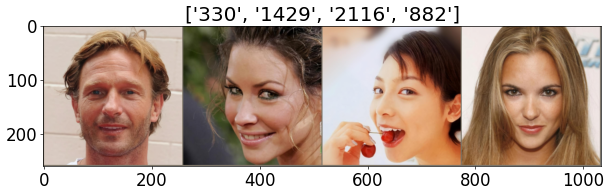

In [3]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})


def imshow(inputs, title):
    # torch.Tensor => numpy
    inputs = inputs.numpy().transpose((1, 2, 0))
    # undo image normalization
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inputs = std * inputs + mean
    inputs = np.clip(inputs, 0, 1)
    # display images
    plt.imshow(inputs)
    plt.title(title)
    plt.show()


# load a batch of train image
iterator = iter(train_dataloader)

# visualize a batch of train image
inputs, classes = next(iterator)
out = torchvision.utils.make_grid(inputs[:4])
imshow(out, title=[class_names[x] for x in classes[:4]])

### <b>Define Model</b>

* We focus on a transfer learning method.

In [20]:
model = models.mnasnet1_0(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

### <b>Training Phase</b>


In [21]:
num_epochs = 120
start_time = time.time()

for epoch in range(num_epochs):
    """ Training Phase """
    model.train()

    running_loss = 0.
    running_corrects = 0

    # load a batch data of images
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward inputs and get output
        optimizer.zero_grad()
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        # get loss value and update the network weights
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects / len(train_dataset) * 100.
    print('[Train #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

    """ Test Phase """
    model.eval()

    with torch.no_grad():
        running_loss = 0.
        running_corrects = 0

        for inputs, labels in test_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(test_dataset)
        epoch_acc = running_corrects / len(test_dataset) * 100.
        print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))

[Train #0] Loss: 5.5580 Acc: 2.6976% Time: 20.5257s
[Test #0] Loss: 5.5211 Acc: 0.9053% Time: 26.9943s
[Train #1] Loss: 4.3505 Acc: 19.9859% Time: 47.5337s
[Test #1] Loss: 5.2670 Acc: 1.8930% Time: 53.7482s
[Train #2] Loss: 3.0502 Acc: 45.3906% Time: 74.5033s
[Test #2] Loss: 4.8502 Acc: 6.1728% Time: 81.0341s
[Train #3] Loss: 2.0376 Acc: 65.0950% Time: 101.2844s
[Test #3] Loss: 4.7807 Acc: 7.2428% Time: 107.6608s
[Train #4] Loss: 1.2825 Acc: 80.1548% Time: 128.2698s
[Test #4] Loss: 4.4665 Acc: 11.0288% Time: 134.7475s
[Train #5] Loss: 0.8053 Acc: 89.2095% Time: 155.9556s
[Test #5] Loss: 4.5489 Acc: 10.1235% Time: 162.3702s
[Train #6] Loss: 0.4860 Acc: 95.0504% Time: 183.2067s
[Test #6] Loss: 4.4627 Acc: 10.8642% Time: 189.6396s
[Train #7] Loss: 0.3164 Acc: 97.6777% Time: 210.3420s
[Test #7] Loss: 4.2920 Acc: 13.0041% Time: 216.6238s
[Train #8] Loss: 0.1937 Acc: 99.2728% Time: 237.2592s
[Test #8] Loss: 4.3565 Acc: 12.1811% Time: 243.7375s
[Train #9] Loss: 0.1366 Acc: 99.7889% Time: 265.

[Train #75] Loss: 0.0046 Acc: 99.9531% Time: 2059.2851s
[Test #75] Loss: 0.9199 Acc: 79.5062% Time: 2065.8067s
[Train #76] Loss: 0.0044 Acc: 99.9765% Time: 2086.2929s
[Test #76] Loss: 0.9097 Acc: 79.6708% Time: 2092.8455s
[Train #77] Loss: 0.0056 Acc: 99.9296% Time: 2112.9425s
[Test #77] Loss: 0.9248 Acc: 79.5885% Time: 2119.2676s
[Train #78] Loss: 0.0056 Acc: 99.9765% Time: 2139.7218s
[Test #78] Loss: 0.9816 Acc: 78.1893% Time: 2146.0264s
[Train #79] Loss: 0.0044 Acc: 99.9765% Time: 2166.6150s
[Test #79] Loss: 0.9382 Acc: 78.6008% Time: 2173.1134s
[Train #80] Loss: 0.0044 Acc: 99.9531% Time: 2193.9019s
[Test #80] Loss: 0.9108 Acc: 79.3416% Time: 2200.4293s
[Train #81] Loss: 0.0040 Acc: 99.9765% Time: 2221.3175s
[Test #81] Loss: 0.9146 Acc: 79.1770% Time: 2227.7945s
[Train #82] Loss: 0.0047 Acc: 99.9531% Time: 2248.9050s
[Test #82] Loss: 0.9261 Acc: 78.6831% Time: 2255.6071s
[Train #83] Loss: 0.0048 Acc: 99.9531% Time: 2276.3327s
[Test #83] Loss: 0.9235 Acc: 78.9300% Time: 2282.9554s
[

### <b>Final Test Phase</b>

* Save the trained model file.

In [22]:
save_path = 'facial_identity_classification_using_transfer_learning_with_MNASNet_resolution_256.pth'
torch.save(model.state_dict(), save_path)

* Load from the trained model file.

In [23]:
model = models.mnasnet1_0(pretrained=True)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, 307) # multi-class classification (num_of_class == 307)
model.load_state_dict(torch.load(save_path))
model.to(device)

MNASNet(
  (layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(16, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
    (8): Sequential(
      (0): _InvertedResidual(
        (layers): Sequential(
          (0): Conv2d(16, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.00029999999999996696, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(48, 

* Evaluate the trained model.

[Original Image Examples]


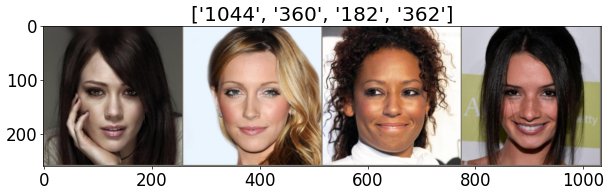

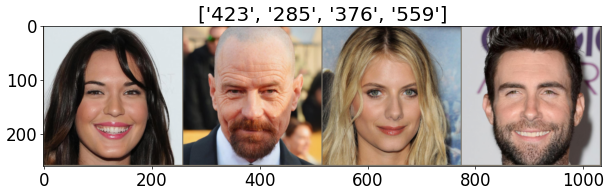

[Prediction Result Examples]


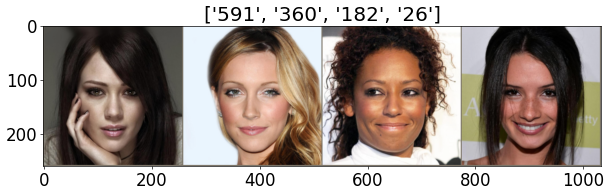

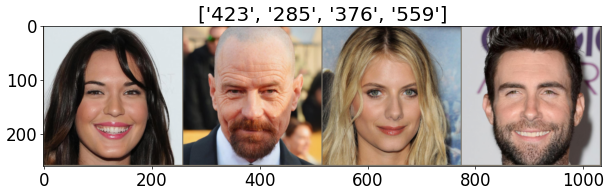

[Test #119] Loss: 0.9011 Acc: 78.8477% Time: 6.6857s


In [24]:
model.eval()
start_time = time.time()

with torch.no_grad():
    running_loss = 0.
    running_corrects = 0

    for i, (inputs, labels) in enumerate(test_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        if i == 0:
            print('[Original Image Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in labels[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in labels[4:8]])
            print('[Prediction Result Examples]')
            images = torchvision.utils.make_grid(inputs[:4])
            imshow(images.cpu(), title=[class_names[x] for x in preds[:4]])
            images = torchvision.utils.make_grid(inputs[4:8])
            imshow(images.cpu(), title=[class_names[x] for x in preds[4:8]])

    epoch_loss = running_loss / len(test_dataset)
    epoch_acc = running_corrects / len(test_dataset) * 100.
    print('[Test #{}] Loss: {:.4f} Acc: {:.4f}% Time: {:.4f}s'.format(epoch, epoch_loss, epoch_acc, time.time() - start_time))